# Case study 2: The T signaling pathway

In [1]:
import networkx as nx
import pandas as pd

from eliater import version_df
from eliater.data import load_sachs_df
from eliater.discover_latent_nodes import (
    find_nuisance_variables,
    mark_nuisance_variables_as_latent,
    remove_nuisance_variables,
)
from eliater.examples import t_cell_signaling_example
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.estimation import estimate_ace
from y0.algorithm.identify import Identification, identify_outcomes
from y0.dsl import P, Variable

version_df()

,key,value
0,eliater,0.0.1-dev-6ad2288f
1,y0,0.2.8-dev-05cee105
2,Run at,2024-01-19 09:17:55


In [2]:
RAF = Variable("Raf")
ERK = Variable("Erk")

This is case study 2 in this paper: Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The Figure below is the protein signalling network (G) of the cell signaling pathway presented in (Sachs et al., 2005). It models the molecular
mechanisms and regulatory processes involved in T cell activation, proliferation, and function.

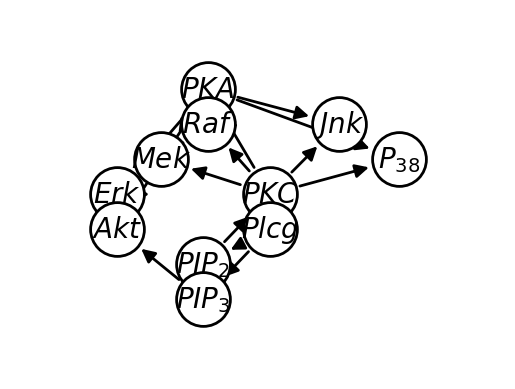

In [3]:
graph = t_cell_signaling_example.graph
graph.draw()

The observational data consisted of quantitative multivariate flow cytometry measurements of phosphorylated proteins derived from thousands of individual primary immune system cells. The cells were subjected to general stimuli meant to activate the desired paths. The distributions of measurements of individual proteins were skewed, and pairs of proteins exhibited nonlinear relationships. To account for that, the data were binned into
two levels corresponding to low, and high concentrations using Hartemink’s approach (Hartemink, 2001) to preserve
the dependence structure of the original data.

In [4]:
data = load_sachs_df()
data.head()

,Raf,Mek,Plcg,PIP2,PIP3,Erk,Akt,PKA,PKC,P38,Jnk
0,0,0,0,1,1,1,0,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1
2,1,0,0,1,1,1,1,1,1,0,0
3,1,0,0,1,1,1,1,1,1,0,0
4,0,0,1,1,0,1,1,1,1,1,1


## Step 1: Verify correctness of the network structure

In [5]:
print_graph_falsifications(graph, data, method="chi-square", verbose=True, significance_level=0.01)

Of the 35 d-separations implied by the network's structure, only 6 (17.14%) rejected the null hypothesis at p<0.01.

Since this is less than 30%, Eliater considers this minor and leaves the network unmodified.


,left,right,given,stats,p,dof,p_adj,p_adj_significant
0,Erk,PIP2,PKC,89.033425,0.000000,2,0.000000,True
1,Plcg,Raf,PKC,249.869064,0.000000,2,0.000000,True
2,Mek,Plcg,PKC,208.486890,0.000000,2,0.000000,True
3,Jnk,P38,PKA|PKC,171.716059,0.000000,4,0.000000,True
4,Erk,PIP3,PKC,478.922745,0.000000,2,0.000000,True
5,Akt,PKC,Erk|PIP3|PKA,38.175853,0.000003,7,0.000084,True
6,PIP3,PKC,PIP2|Plcg,17.205217,0.001763,4,0.051135,False
7,P38,Plcg,PKC,8.179063,0.016747,2,0.468918,False
8,P38,PIP2,PKC,0.564378,0.754131,2,1.000000,False
9,PKA,Plcg,PKC,0.344113,0.841932,2,1.000000,False


Out of 35 d-separations implied by the network, six failed. As the precentage of failed tests is below 30 percent, its effect on the estimation of causal query is minor. Hence, we proceed to the next step.

## Step 2: Check query identifiability

If the query is identifiable, the $Y_0$ package will return its estimand. Otherwise, nothing will be shown.

In [6]:
identify_outcomes(graph=graph, treatments=RAF, outcomes=ERK)

Sum[Mek, PIP2, PIP3, PKA, PKC, Plcg](P(Erk | Mek, PIP2, PIP3, PKA, PKC, Plcg, Raf) * P(Mek | PIP2, PIP3, PKA, PKC, Plcg, Raf) * P(PIP2 | PIP3, Plcg) * P(PIP3 | Plcg) * P(PKA | PIP2, PIP3, PKC, Plcg) * P(PKC | PIP2, PIP3, Plcg) * Sum[Erk, Mek, PIP2, PIP3, PKA, PKC, Raf](Sum[Akt, Jnk, P38](P(Akt, Erk, Jnk, Mek, P38, PIP2, PIP3, PKA, PKC, Plcg, Raf))))

The query is identifiable. Hence, we can proceed to the next step.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [7]:
nuisance_variables = find_nuisance_variables(graph, treatments=RAF, outcomes=ERK)

print(f"The nuisance variables are {nuisance_variables}")

The nuisance variables are {Akt}


In [8]:
latent_variable_dag = mark_nuisance_variables_as_latent(
    graph,
    treatments=RAF,
    outcomes=ERK,
)

## Step 4: Simplify the network

In eliater, step 3, and 4 are both combined into a single function. Hence, the following function finds the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules (Step 4) to remove the nuisance variables. As a result, running the 'find_nuisance_variables' and 'mark_nuisance_variables_as_latent' functions is not necessary to get the value of step 4. However, we called them to illustrate the results. The new graph obtained in step 4 does not contain nuisance variables. 

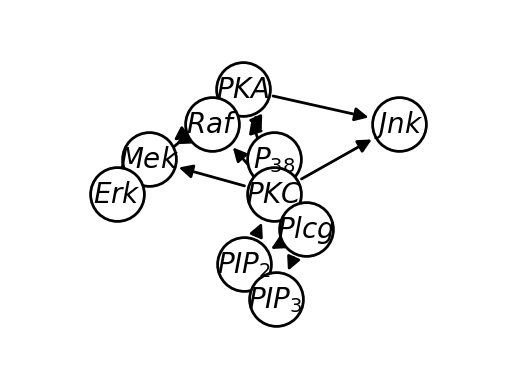

In [9]:
new_graph = remove_nuisance_variables(graph, treatments=RAF, outcomes=ERK)
new_graph.draw()

## Step 5: Estimate the query

In [10]:
estimate_ace(new_graph, treatments=RAF, outcomes=ERK, data=data)

-0.30580881280674466